In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs

import cubedsphere as cs
import xesmf as xe

In [2]:
maindir = '/n/home03/zhuangjw/seasasfs/fromPleiades/output_FV3/C48/C48L20/'
ds = cs.open_FV3data(maindir,'winds_daily')
ds

<xarray.Dataset>
Dimensions:  (pfull: 20, phalf: 21, tile: 6, time: 8, x: 48, x_b: 49, y: 48, y_b: 49)
Coordinates:
  * x        (x) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0 ...
  * y        (y) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0 ...
  * pfull    (pfull) float64 7.673 47.07 100.7 152.7 204.4 255.8 307.2 358.6 ...
  * phalf    (phalf) float64 1.0 26.0 77.26 128.5 179.8 231.1 282.3 333.6 ...
  * time     (time) float64 9.0 10.0 11.0 12.0 13.0 14.0 15.0 16.0
    lon      (tile, y, x) float32 305.783 307.37 308.986 310.631 312.306 ...
    lat      (tile, y, x) float32 -34.8911 -35.5988 -36.2858 -36.951 ...
  * x_b      (x_b) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 ...
  * y_b      (y_b) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 ...
    lon_b    (tile, y_b, x_b) float32 305.0 306.573 308.174 309.805 311.465 ...
    lat_b    (tile, y_b, x_b) float32 -35.2644 -35.9889 -36.6926 -37.3743 ...
    area     (tile, y, x) float32 2.

In [4]:
dr_u = ds['u850'].load()
dr_v = ds['v850'].load()

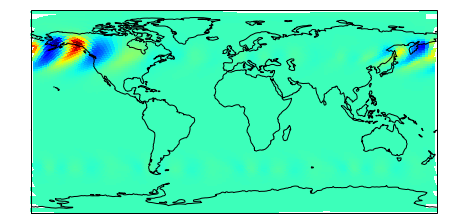

In [5]:
fig = plt.figure(figsize=[8,6])
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

cs.plotCS_quick(dr_v.isel(time=0), ds, ax, cmap='jet')

In [6]:
ds_out = xe.grid_global(2.5, 2)
ds_out

<xarray.Dataset>
Dimensions:  (x: 144, x_b: 145, y: 90, y_b: 91)
Coordinates:
    lon      (y, x) float64 -178.8 -176.2 -173.8 -171.2 -168.8 -166.2 -163.8 ...
    lat      (y, x) float64 -89.0 -89.0 -89.0 -89.0 -89.0 -89.0 -89.0 -89.0 ...
    lon_b    (y_b, x_b) float64 -180.0 -177.5 -175.0 -172.5 -170.0 -167.5 ...
    lat_b    (y_b, x_b) int64 -90 -90 -90 -90 -90 -90 -90 -90 -90 -90 -90 ...
Dimensions without coordinates: x, x_b, y, y_b
Data variables:
    *empty*

In [7]:
def C2L(ds_in, ds_out, dr_in):
    
    for k in range(6):
        print(k, end=' ')
        dr_temp = xe.regrid(ds_in.isel(tile=k), ds_out, 
                            dr_in.isel(tile=k), method='conservative')
        if k==0:
            dr_out = dr_temp
        else:
            dr_out += dr_temp
    
    return  dr_out

In [8]:
u_out = C2L(ds, ds_out, dr_u)

0 1 2 3 4 5 

In [9]:
v_out = C2L(ds, ds_out, dr_v)

0 1 2 3 4 5 

In [11]:
ds_out['u850'] = u_out
ds_out['v850'] = v_out
ds_out

<xarray.Dataset>
Dimensions:  (time: 8, x: 144, x_b: 145, y: 90, y_b: 91)
Coordinates:
    lon      (y, x) float64 -178.8 -176.2 -173.8 -171.2 -168.8 -166.2 -163.8 ...
    lat      (y, x) float64 -89.0 -89.0 -89.0 -89.0 -89.0 -89.0 -89.0 -89.0 ...
    lon_b    (y_b, x_b) float64 -180.0 -177.5 -175.0 -172.5 -170.0 -167.5 ...
    lat_b    (y_b, x_b) int64 -90 -90 -90 -90 -90 -90 -90 -90 -90 -90 -90 ...
  * time     (time) float64 9.0 10.0 11.0 12.0 13.0 14.0 15.0 16.0
Dimensions without coordinates: x, x_b, y, y_b
Data variables:
    u850     (time, y, x) float64 0.04737 0.04737 0.04737 0.04737 0.04737 ...
    v850     (time, y, x) float64 -0.002533 -0.002533 -0.002533 -0.002533 ...

In [12]:
outputdir = '../../outputdata/regridded/'
ds_out.to_netcdf(outputdir+'C48L20_wind850.nc')

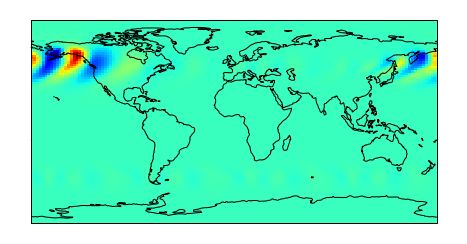

In [13]:
fig = plt.figure(figsize=[8,6])
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

ax.pcolormesh(ds_out['lon_b'],ds_out['lat_b'],v_out.isel(time=0).values,cmap='jet')

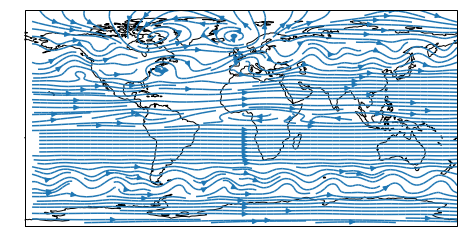

In [16]:
t=4
fig = plt.figure(figsize=[8,6])
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

ax.streamplot(ds_out['lon'].values,ds_out['lat'].values,
              u_out.isel(time=t).values, v_out.isel(time=t).values,
              density=2)